In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### Import the QmioBackend code

In [2]:
from qmiotools.integrations.qiskitqmio import QmioBackend

In [11]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import transpile
from qiskit.visualization import plot_gate_map
from qiskit import qasm3

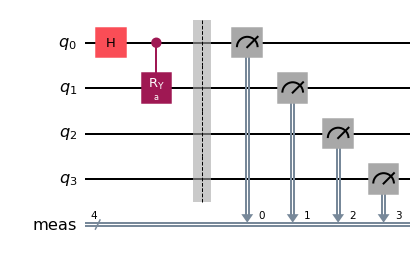

In [12]:
c=QuantumCircuit(4)
a=Parameter("a")
c.h(0)
c.cry(a, 0,1)
c.measure_all()
c.draw(output="mpl")

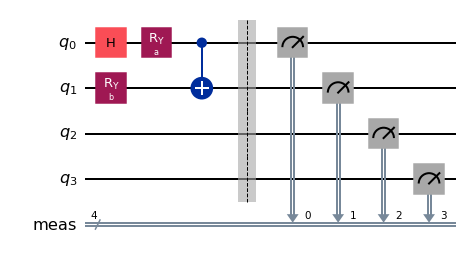

In [13]:
c2=QuantumCircuit(4)
a=Parameter("a")
b=Parameter("b")
c2.h(0)
c2.ry(a, 0)
c2.ry(b, 1)
c2.cx(0,1)
c2.measure_all()
c2.draw(output="mpl")

In [14]:
qmio=QmioBackend()

Importing calibrations from  /opt/cesga/qmio/hpc/software/Core/qmio-tools/0.0.1-python-3.9.9/qmio-tools/calibrations/2024_05_11__13_27_21.json


15


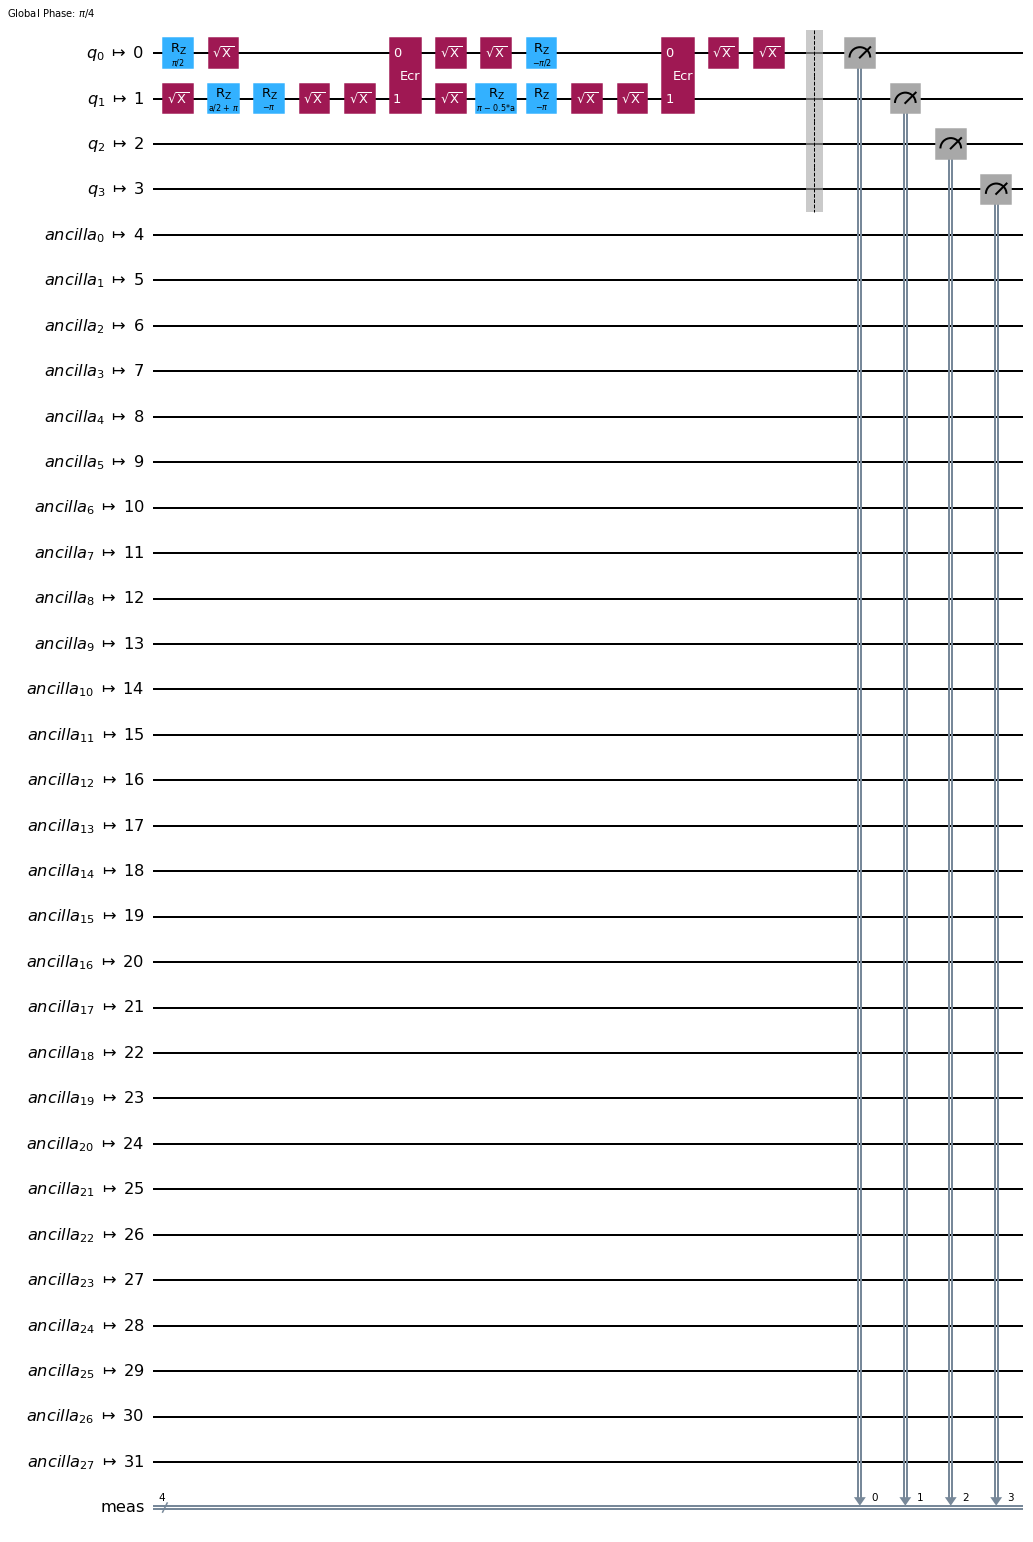

In [17]:
d=transpile(c,qmio)
print(d.depth())
d.draw(output="mpl")

10


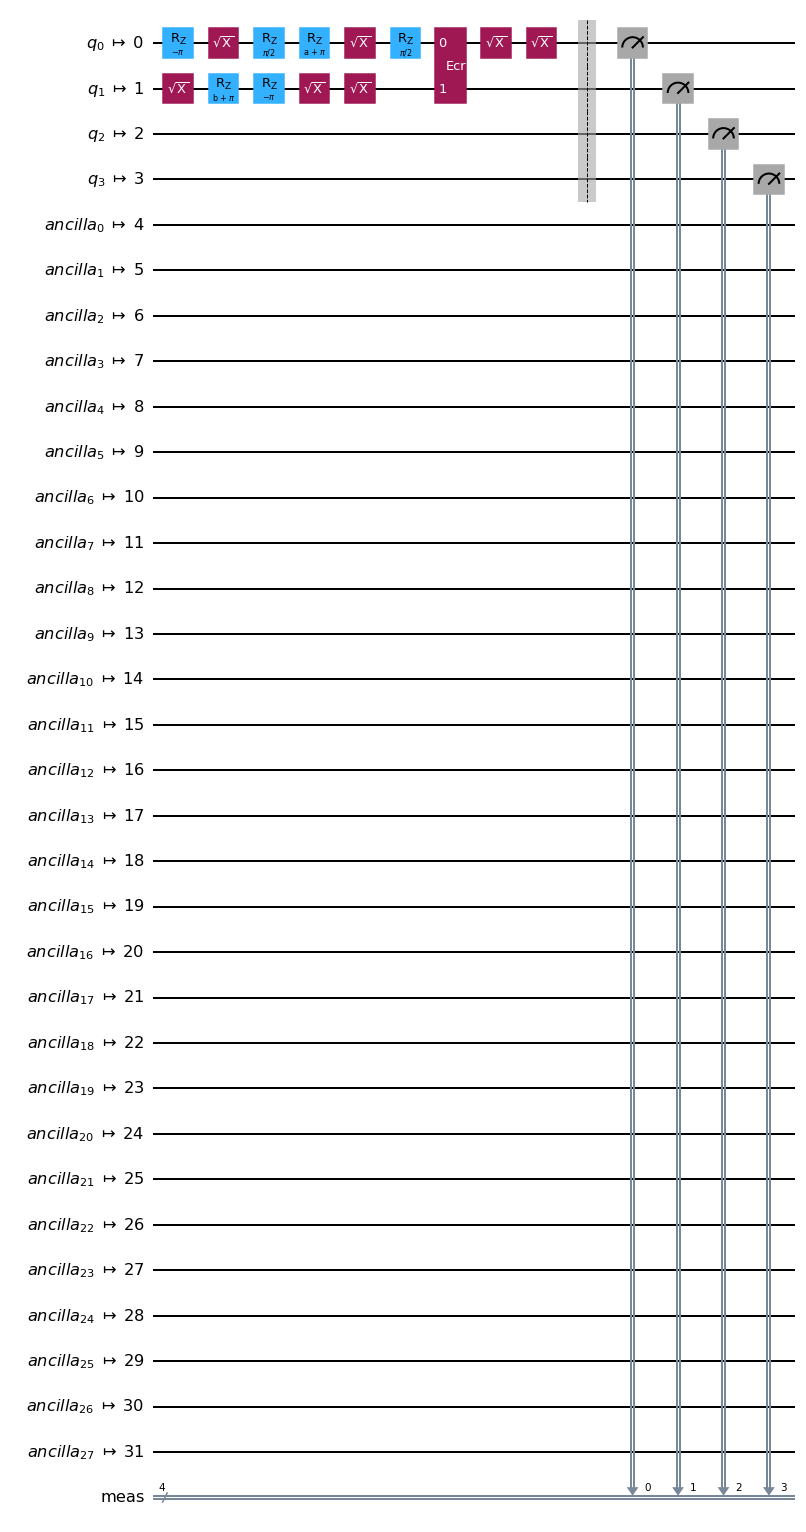

In [18]:
d=transpile(c2,qmio)
print(d.depth())
d.draw(output="mpl")

In [21]:
from qmio.backends import QPUBackend, _config_build
def run2(self, circuit, shots, repetition_period=400e-6):
    if not self.client:
        raise RuntimeError("Not connected to the server")
    print("LLamando a run2 con %f"%repetition_period)

    config = _config_build(shots,repetition_period=repetition_period)
    #print(config)
    job = (circuit, config)
    self.client._send(job)
    result = self.client._await_results()
    return result

    
class QmioRuntimeService():
    QPUBackend.run=run2
    def backend(self, name):
        if name == "qpu":
            return QPUBackend()
        # if name == "qulacs":
        #     pass
        else:
            raise ValueError(f"Backend unknown: {name}")

### Create an instance of the QMIO backend, loading he last calibration from the directory given by the QMIO_CALIBRATIONS environ

In [29]:
from typing import Union, List
#from qiskit.circuit import Schedule
from qiskit.pulse import Schedule
from qiskit.providers import QubitProperties, BackendV2, Provider, Options, Job, JobStatus

from qmiotools.integrations.qiskitqmio import QmioJob

from datetime import date
import uuid
from dataclasses import dataclass
from qiskit.result import Result, Counts 

class QPUException(Exception):
    pass

def run2(self, circuit, shots, repetition_period=400e-6):
    if not self.client:
        raise RuntimeError("Not connected to the server")
    print("LLamando a run2 con %f"%repetition_period)

    config = _config_build(shots,repetition_period=repetition_period)
    #print(config)
    job = (circuit, config)
    self.client._send(job)
    result = self.client._await_results()
    return result
@dataclass
class QasmCircuit():
    circuit=None
    name=None
    
class QmioRuntimeService():
    QPUBackend.run=run2
    def backend(self, name):
        if name == "qpu":
            return QPUBackend()
        # if name == "qulacs":
        #     pass
        else:
            raise ValueError(f"Backend unknown: {name}")
def run_experimental(self, run_input: Union[Union[QuantumCircuit,Schedule, str],List[Union[QuantumCircuit,Schedule,str]]], **options):
    """Run on the backend.



    Args:
        run_input (QuantumCircuit or Schedule or Str - a QASM string - or list): An
            individual or a list of :class:`.QuantumCircuit`,
            or :class:`~qiskit.pulse.Schedule` or a string with a QASM 3.0 objects to
            run on the backend.
        options: Any kwarg options to pass to the backend for running the
            config. If a key is also present in the options
            attribute/object then the expectation is that the value
            specified will be used instead of what's set in the options
            object.

    Returns:
        Job: The job object for the run
    """

    if isinstance(options,Options):
        shots=options.get("shots",default=self._options.get("shots"))
        memory=options.get("memory",default=self._options.get("shots"))
        repetition_period=options.get("repetition_period",default=self._options.get("repetition_period"))
    else:
        if "shots" in options:
            shots=options["shots"]
        else:
            shots=self._options.get("shots")

        if "memory" in options:
            shots=options["memory"]
        else:
            memory=self._options.get("memory")

        if "repetition_period" in options:
            repetition_period=options["repetition_period"]
        else:
            repetition_period=self._options.get("repetition_period")


    if isinstance(run_input,QuantumCircuit) or isinstance(run_input,Schedule) or isinstance(run_input,str):
        circuits=[run_input]
    else:
        circuits=run_input

    if shots*len(circuits) > self.max_shots:
        raise RuntimeError("Total number of shots %d larger than capacity %d"%(shots,self.max_shots))


    service = QmioRuntimeService()
    #print(service)
    job_id=uuid.uuid4()
    ExpResult=[]
    with service.backend(name="qpu") as backend:
        for c in circuits:
            if isinstance(c,QuantumCircuit) or isinstance(c,Schedule):
                qasm=qasm3.dumps(c, basis_gates=self.operation_names).replace("\n","")
                print(qasm)
            else:
                qasm=c
            remain_shots=shots
            ExpDict={}
            backend.run2=run2

            while (remain_shots > 0):
                results = backend.run(circuit=qasm, shots=min(self._max_shots,remain_shots),repetition_period=repetition_period)
                #print("Results:",results)
                if "Exception" in results:
                    raise QPUException(results["Exception"])
                try:
                    r=results["results"][list(results["results"].keys())[0]]
                except:
                    raise QPUException("QPU does not return results")
                for k in r:
                    if not memory:
                        key=hex(int(k[::-1],base=2))
                        ExpDict[key]=ExpDict[key]+r[k] if key in ExpDict else r[k]
                    else:
                        raise RuntimeError("Binary for the next version")
                remain_shots=remain_shots-self._max_shots
            metadata=None
            #print(ExpDict)
            if "execution_metrics" in results:
                metadata=results["execution_metrics"] 
            """ExpResult.append(ExperimentResult(
                shots,
                success=True,
                data=Counts(ExpDict),
                meas_level=MeasLevel.CLASSIFIED,
                status=None,
                seed=None,
                meas_return=None,
                header=QobjExperimentHeader.from_dict({"name":c.name,"metadata":metadata})))"""
            if isinstance(c,str):
                c_copy=c
                c=QasmCircuit()
                c.circuit=c_copy
                c.name="QASM"
                print(c)
                
            dd={
                'shots': shots,
                'success': True,
                'data': {

                    'counts': ExpDict,
                    'metadata': None,
                },
                'header': {'name': c.name},

                }
            ExpResult.append(dd)

    result_dict = {
        'backend_name': self._name,
        'backend_version': self._version,
        'qobj_id': None,
        'job_id': job_id,
        'success': True,
        'results': ExpResult,
        'date': date.today().isoformat(),

    }
    #print(ExpResult)
    results=Result.from_dict(result_dict)
    
    job=QmioJob(backend=self,job_id=uuid.uuid4(), jobstatus=JobStatus.DONE, 
result=results)
    return job

QmioBackend.run=run_experimental
backend=QmioBackend()

Importing calibrations from  /opt/cesga/qmio/hpc/software/Core/qmio-tools/0.0.1-python-3.9.9/qmio-tools/calibrations/2024_05_11__13_27_21.json


In [22]:
backend=QmioBackend()

Importing calibrations from  /opt/cesga/qmio/hpc/software/Core/qmio-tools/0.0.1-python-3.9.9/qmio-tools/calibrations/2024_05_11__13_27_21.json


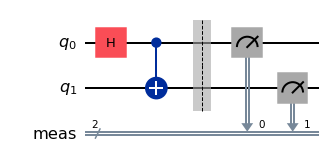

In [23]:
%matplotlib inline
c=QuantumCircuit(2)
c.h(0)
c.cx(0,1)
c.measure_all()
c.draw(output="mpl")

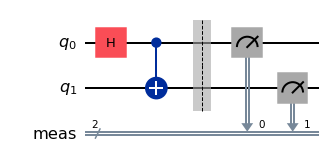

In [24]:
d=c.copy()
d.draw(output="mpl")

In [25]:
qc_basis = transpile(c, backend)
#qc_basis.draw(output="mpl")

In [26]:
qd_basis = transpile(d, backend)
#qd_basis.draw(output="mpl")

In [27]:
c=QuantumCircuit(2)
c.measure_all()
c.delay(1e-6,unit="s")
c.name="ONLY INIT"
qasm3.dumps(c)

'OPENQASM 3.0;\ninclude "stdgates.inc";\nbit[2] meas;\nqubit[2] q;\nbarrier q[0], q[1];\nmeas[0] = measure q[0];\nmeas[1] = measure q[1];\ndelay[1e-06s] q[0];\ndelay[1e-06s] q[1];\n'

In [28]:
shots=200
repetition_period=0.1
job=backend.run([c,d], shots=shots, repetition_period=repetition_period)

OPENQASM 3.0;include "stdgates.inc";bit[2] meas;qubit[2] q;barrier q[0], q[1];meas[0] = measure q[0];meas[1] = measure q[1];delay[1e-06s] q[0];delay[1e-06s] q[1];
LLamando a run2 con 0.100000


KeyboardInterrupt: 

In [12]:
c=QuantumCircuit(2)
c.measure_all()
#c.delay(1e-6,unit="s")
c.name="ONLY INIT"
d=QuantumCircuit(2)
d.x(0)
d.measure_all()
d.name="X in cubit 0"
c=transpile(c,backend,optimization_level=3)
d=transpile(d,backend,optimization_level=2)
c.draw()
c="""
OPENQASM 3.0;include "stdgates.inc";bit[2] meas;barrier $0, $1;meas[0] = measure $0;meas[1] = measure $1;
"""
d="""
OPENQASM 3.0;include "stdgates.inc";bit[2] meas;sx $0;sx $0;barrier $0, $1;meas[0] = measure $0;meas[1] = measure $1;
"""
e="""
OPENQASM 3.0;include "stdgates.inc";bit[2] meas;sx $1;sx $1;barrier $0, $1;meas[0] = measure $0;meas[1] = measure $1;
"""

print(c)


OPENQASM 3.0;include "stdgates.inc";bit[2] meas;barrier $0, $1;meas[0] = measure $0;meas[1] = measure $1;



# These cells only work if executed in a node with connection to the QPU

LLamando a run2 con 0.100000
QasmCircuit()
LLamando a run2 con 0.100000
QasmCircuit()
LLamando a run2 con 0.100000
QasmCircuit()
[{'0': 176, '10': 12, '1': 12}, {'1': 165, '0': 31, '11': 3, '10': 1}, {'10': 170, '0': 16, '11': 13, '1': 1}]


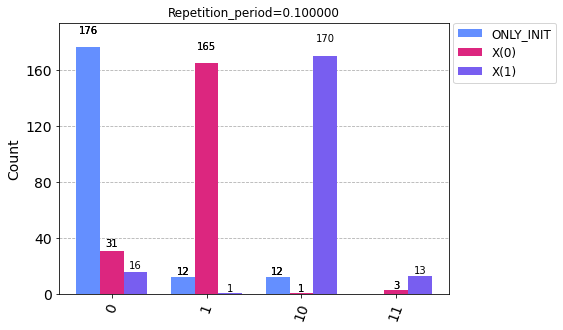

In [13]:
shots=200
repetition_period=0.1
job=backend.run([c,d,e], shots=shots, repetition_period=repetition_period)
#print(job.result())
print(job.result().get_counts())
from qiskit.visualization import plot_histogram
plot_histogram(job.result().get_counts(), title="Repetition_period=%f"%repetition_period,legend=["ONLY_INIT","X(0)","X(1)"])

LLamando a run2 con 0.010000
QasmCircuit()
LLamando a run2 con 0.010000
QasmCircuit()
LLamando a run2 con 0.010000
QasmCircuit()
[{'0': 180, '10': 11, '1': 9}, {'1': 167, '11': 11, '0': 20, '10': 2}, {'10': 170, '0': 23, '11': 6, '1': 1}]


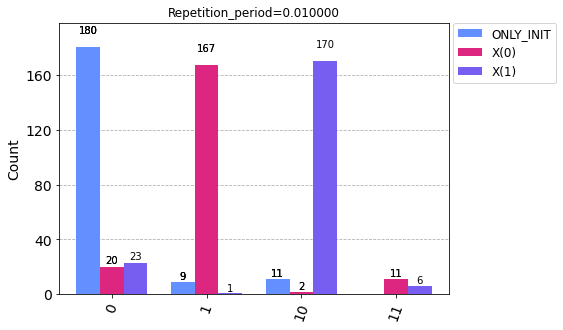

In [15]:
repetition_period=0.01
job=backend.run([c,d,e], shots=shots, repetition_period=repetition_period)
#print(job.result())
print(job.result().get_counts())
from qiskit.visualization import plot_histogram
plot_histogram(job.result().get_counts(), title="Repetition_period=%f"%repetition_period,legend=["ONLY_INIT","X(0)","X(1)"])

LLamando a run2 con 0.001000
QasmCircuit()
LLamando a run2 con 0.001000
QasmCircuit()
LLamando a run2 con 0.001000
QasmCircuit()
[{'0': 181, '1': 12, '10': 6, '11': 1}, {'1': 158, '0': 32, '11': 7, '10': 3}, {'10': 161, '0': 18, '11': 21}]


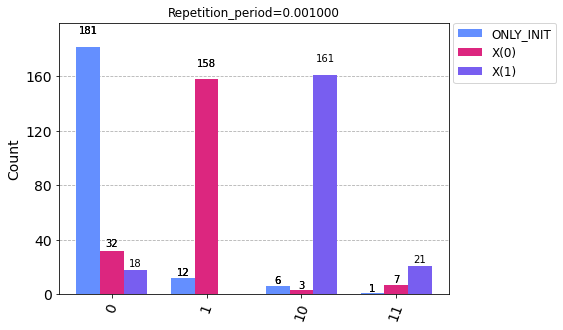

In [16]:
repetition_period=0.001
job=backend.run([c,d,e], shots=shots, repetition_period=repetition_period)
#print(job.result())
print(job.result().get_counts())
from qiskit.visualization import plot_histogram
plot_histogram(job.result().get_counts(), title="Repetition_period=%f"%repetition_period,legend=["ONLY_INIT","X(0)","X(1)"])

LLamando a run2 con 0.000100
QasmCircuit()
LLamando a run2 con 0.000100
QasmCircuit()
LLamando a run2 con 0.000100
QasmCircuit()
[{'0': 169, '10': 17, '1': 12, '11': 2}, {'11': 14, '1': 150, '0': 32, '10': 4}, {'10': 149, '0': 37, '11': 11, '1': 3}]


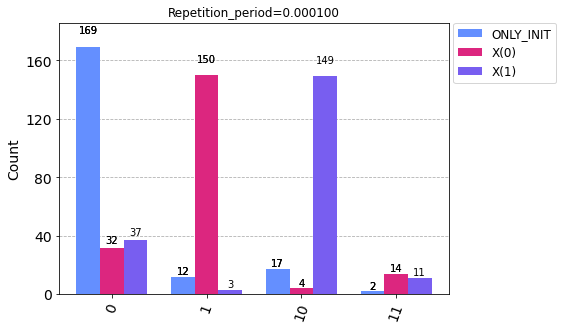

In [17]:
repetition_period=0.0001
job=backend.run([c,d,e], shots=shots, repetition_period=repetition_period)
#print(job.result())
print(job.result().get_counts())
from qiskit.visualization import plot_histogram
plot_histogram(job.result().get_counts(), title="Repetition_period=%f"%repetition_period,legend=["ONLY_INIT","X(0)","X(1)"])

LLamando a run2 con 0.000010
QasmCircuit()
LLamando a run2 con 0.000010
QasmCircuit()
LLamando a run2 con 0.000010
QasmCircuit()
[{'0': 157, '1': 10, '11': 4, '10': 29}, {'1': 94, '0': 51, '10': 25, '11': 30}, {'10': 90, '0': 83, '11': 16, '1': 11}]


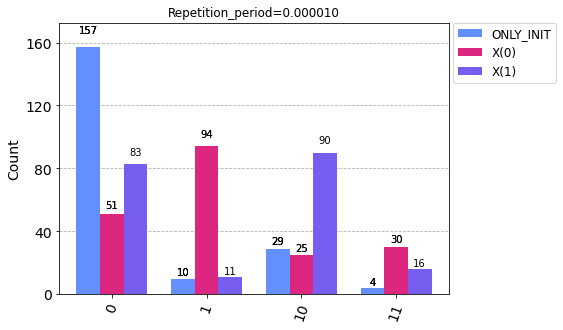

In [18]:
repetition_period=0.00001
job=backend.run([c,d,e], shots=shots, repetition_period=repetition_period)
#print(job.result())
print(job.result().get_counts())
from qiskit.visualization import plot_histogram
plot_histogram(job.result().get_counts(), title="Repetition_period=%f"%repetition_period,legend=["ONLY_INIT","X(0)","X(1)"])

LLamando a run2 con 0.000100
QasmCircuit()
LLamando a run2 con 0.000100
QasmCircuit()
LLamando a run2 con 0.000100
QasmCircuit()
[{'0': 170, '1': 11, '10': 17, '11': 2}, {'1': 137, '0': 34, '11': 24, '10': 5}, {'10': 144, '0': 39, '11': 15, '1': 2}]


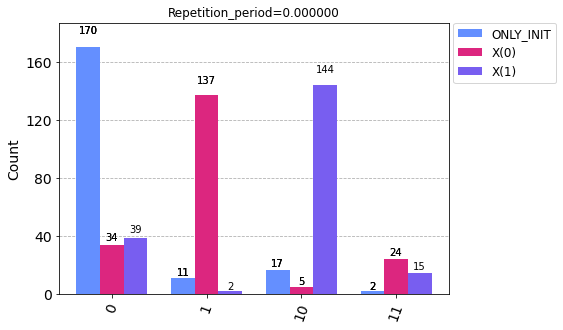

In [19]:
repetition_period=0
job=backend.run([c,d,e], shots=shots)
#print(job.result())
print(job.result().get_counts())
from qiskit.visualization import plot_histogram
plot_histogram(job.result().get_counts(), title="Repetition_period=%f"%repetition_period,legend=["ONLY_INIT","X(0)","X(1)"])

In [20]:
jobs=[]
shots=1000
for i in range(10):
    repetition_period=100e-6*(i+1)
    job=backend.run([c,d,e], shots=shots, repetition_period=repetition_period)
    jobs.append(job)
    print(repetition_period,job.result().get_counts())
    #plot_histogram(job.result().get_counts(), title="Repetition_period=%f"%repetition_period,legend=["ONLY_INIT","X(0)","X(1)"])

LLamando a run2 con 0.000100
QasmCircuit()
LLamando a run2 con 0.000100
QasmCircuit()
LLamando a run2 con 0.000100
QasmCircuit()
0.0001 [{'1': 68, '0': 849, '10': 73, '11': 10}, {'1': 697, '0': 167, '10': 23, '11': 113}, {'10': 740, '0': 184, '1': 18, '11': 58}]
LLamando a run2 con 0.000200
QasmCircuit()
LLamando a run2 con 0.000200
QasmCircuit()
LLamando a run2 con 0.000200
QasmCircuit()
0.0002 [{'0': 861, '10': 70, '11': 4, '1': 65}, {'1': 802, '0': 123, '11': 67, '10': 8}, {'10': 821, '11': 58, '0': 119, '1': 2}]
LLamando a run2 con 0.000300
QasmCircuit()
LLamando a run2 con 0.000300
QasmCircuit()
LLamando a run2 con 0.000300
QasmCircuit()
0.00030000000000000003 [{'0': 885, '10': 44, '1': 69, '11': 2}, {'11': 41, '1': 809, '0': 134, '10': 16}, {'10': 841, '0': 97, '11': 57, '1': 5}]
LLamando a run2 con 0.000400
QasmCircuit()
LLamando a run2 con 0.000400
QasmCircuit()
LLamando a run2 con 0.000400
QasmCircuit()
0.0004 [{'0': 852, '1': 85, '10': 56, '11': 7}, {'0': 141, '1': 792, '11':

In [50]:
d="""
OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $0;sx $0;delay[{0}us] $0;barrier $0;meas[0] = measure $0;
"""
d.format(10)

'\nOPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $0;sx $0;delay[10us] $0;barrier $0;meas[0] = measure $0;\n'

LLamando a run2 con 0.000500
QasmCircuit()
0 0 {'0': 139, '1': 861}
LLamando a run2 con 0.000500
QasmCircuit()
10 1 {'0': 292, '1': 708}
LLamando a run2 con 0.000500
QasmCircuit()
20 2 {'1': 567, '0': 433}
LLamando a run2 con 0.000500
QasmCircuit()
30 3 {'0': 523, '1': 477}
LLamando a run2 con 0.000500
QasmCircuit()
40 4 {'0': 586, '1': 414}
LLamando a run2 con 0.000500
QasmCircuit()
50 5 {'1': 303, '0': 697}
LLamando a run2 con 0.000500
QasmCircuit()
60 6 {'0': 692, '1': 308}
LLamando a run2 con 0.000500
QasmCircuit()
70 7 {'0': 788, '1': 212}
LLamando a run2 con 0.000500
QasmCircuit()
80 8 {'0': 814, '1': 186}
LLamando a run2 con 0.000500
QasmCircuit()
90 9 {'0': 824, '1': 176}
LLamando a run2 con 0.000500
QasmCircuit()
100 10 {'0': 812, '1': 188}
LLamando a run2 con 0.000500
QasmCircuit()
110 11 {'1': 153, '0': 847}
LLamando a run2 con 0.000500
QasmCircuit()
120 12 {'0': 885, '1': 115}
LLamando a run2 con 0.000500
QasmCircuit()
130 13 {'0': 870, '1': 130}
LLamando a run2 con 0.00050

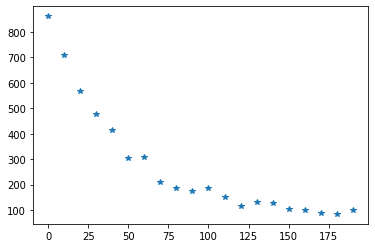

In [51]:
import matplotlib.pyplot as plt
jobs=[]
counts=[]
shots=1000
Times=20
for i in range(Times):
    delay=(i)*10
    rund=d.format(delay)
    repetition_period=400e-6*(i+1)
    job=backend.run(rund, shots=shots, repetition_period=500e-6)
    jobs.append(job)
    print(delay, i,job.result().get_counts())
    counts.append(job.result().get_counts()["1"])
plt.plot([j*10 for j in range(Times)], counts,"*")

In [60]:
d="""
OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx ${0};sx ${0};delay[{1}us] ${0};barrier ${0};meas[0] = measure ${0};
"""
d.format(1,10)

'\nOPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $1;sx $1;delay[10us] $1;barrier $1;meas[0] = measure $1;\n'

LLamando a run2 con 0.000500
QasmCircuit()
0 0 {'0': 114, '1': 886}
LLamando a run2 con 0.000500
QasmCircuit()
10 1 {'1': 657, '0': 343}
LLamando a run2 con 0.000500
QasmCircuit()
20 2 {'0': 471, '1': 529}
LLamando a run2 con 0.000500
QasmCircuit()
30 3 {'0': 553, '1': 447}
LLamando a run2 con 0.000500
QasmCircuit()
40 4 {'1': 369, '0': 631}
LLamando a run2 con 0.000500
QasmCircuit()
50 5 {'1': 267, '0': 733}
LLamando a run2 con 0.000500
QasmCircuit()
60 6 {'0': 748, '1': 252}
LLamando a run2 con 0.000500
QasmCircuit()
70 7 {'0': 809, '1': 191}
LLamando a run2 con 0.000500
QasmCircuit()
80 8 {'0': 804, '1': 196}
LLamando a run2 con 0.000500
QasmCircuit()
90 9 {'0': 825, '1': 175}
LLamando a run2 con 0.000500
QasmCircuit()
100 10 {'0': 861, '1': 139}
LLamando a run2 con 0.000500
QasmCircuit()
110 11 {'0': 862, '1': 138}
LLamando a run2 con 0.000500
QasmCircuit()
120 12 {'0': 889, '1': 111}
LLamando a run2 con 0.000500
QasmCircuit()
130 13 {'0': 895, '1': 105}
LLamando a run2 con 0.00050

Text(0.5, 1.0, 'Qubit 0')

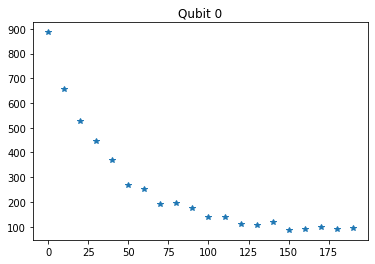

In [56]:
import matplotlib.pyplot as plt
jobs=[]
counts=[]
shots=1000
Times=20
qubit=0
for i in range(Times):
    delay=(i)*10
    rund=d.format(qubit,delay)
    repetition_period=400e-6*(i+1)
    job=backend.run(rund, shots=shots, repetition_period=500e-6)
    jobs.append(job)
    print(delay, i,job.result().get_counts())
    counts.append(job.result().get_counts()["1"])
plt.plot([j*10 for j in range(Times)], counts,"*")
plt.title("Qubit %d"%qubit)


OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $1;sx $1;delay[0us] $1;barrier $1;meas[0] = measure $1;

LLamando a run2 con 0.000500
QasmCircuit()
0 0 {'1': 924, '0': 76}

OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $1;sx $1;delay[10us] $1;barrier $1;meas[0] = measure $1;

LLamando a run2 con 0.000500
QasmCircuit()
10 1 {'0': 270, '1': 730}

OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $1;sx $1;delay[20us] $1;barrier $1;meas[0] = measure $1;

LLamando a run2 con 0.000500
QasmCircuit()
20 2 {'1': 610, '0': 390}

OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $1;sx $1;delay[30us] $1;barrier $1;meas[0] = measure $1;

LLamando a run2 con 0.000500
QasmCircuit()
30 3 {'0': 512, '1': 488}

OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $1;sx $1;delay[40us] $1;barrier $1;meas[0] = measure $1;

LLamando a run2 con 0.000500
QasmCircuit()
40 4 {'1': 464, '0': 536}

OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $1;sx $1;delay[50us] $1;barrier $1;meas[0] = measure $1;

Text(0.5, 1.0, 'Qubit 1')

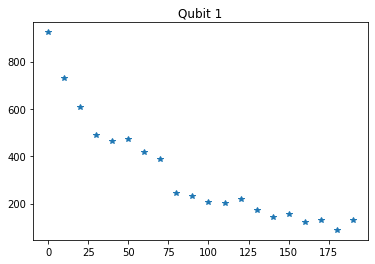

In [61]:
import matplotlib.pyplot as plt
jobs=[]
counts=[]
shots=1000
Times=20
qubit=1
for i in range(Times):
    delay=(i)*10
    rund=d.format(qubit,delay)
    print(rund)
    repetition_period=400e-6*(i+1)
    job=backend.run(rund, shots=shots, repetition_period=500e-6)
    jobs.append(job)
    print(delay, i,job.result().get_counts())
    counts.append(job.result().get_counts()["1"])
plt.plot([j*10 for j in range(Times)], counts,"*")
plt.title("Qubit %d"%qubit)

In [ ]:
import matplotlib.pyplot as plt
jobs=[]
counts=[]
shots=1000
Times=20
qubit=2
for i in range(Times):
    delay=(i)*10
    rund=d.format(qubit,delay)
    print(rund)
    repetition_period=400e-6*(i+1)
    job=backend.run(rund, shots=shots, repetition_period=500e-6)
    jobs.append(job)
    print(delay, i,job.result().get_counts())
    counts.append(job.result().get_counts()["1"])
plt.plot([j*10 for j in range(Times)], counts,"*")
plt.title("Qubit %d"%qubit)


OPENQASM 3.0;include "stdgates.inc";bit[1] meas;sx $2;sx $2;delay[0us] $2;barrier $2;meas[0] = measure $2;

LLamando a run2 con 0.000500


In [33]:
c=QuantumCircuit(2)
c.x(0)
c.delay(1, unit="us")
c.measure_all()
c.name="ONLY INIT"
qasm3.dumps(c)

'OPENQASM 3.0;\ninclude "stdgates.inc";\nbit[2] meas;\nqubit[2] q;\nx q[0];\ndelay[1us] q[0];\ndelay[1us] q[1];\nbarrier q[0], q[1];\nmeas[0] = measure q[0];\nmeas[1] = measure q[1];\n'

In [34]:
job=backend.run(c, shots=shots, repetition_period=repetition_period)

OPENQASM 3.0;include "stdgates.inc";bit[2] meas;qubit[2] q;x q[0];delay[1us] q[0];delay[1us] q[1];barrier q[0], q[1];meas[0] = measure q[0];meas[1] = measure q[1];
LLamando a run2 con 0.000400
